# Deep Learning
## Assignment 3
Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [33]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle

%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = './data/notMNIST/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [24]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

<hr>
## Problem 1
Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.


In [25]:
batch_size = 128
num_labels = 10

graphLogistic = tf.Graph()
with graphLogistic.as_default():
    
    # Datasets and labels
    tf_train_data = tf.placeholder(tf.float32,
                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    
    # Weights and Biases
    beta = tf.placeholder(tf.float32) # Regularization parameter - fed in during training
    weights = tf.Variable(
                tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Logits
    logits = tf.matmul(tf_train_data, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) +
        beta * tf.nn.l2_loss(weights))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Prediction
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
            tf.matmul(tf_valid_data, weights) + biases)
    test_prediction = tf.nn.softmax(
            tf.matmul(tf_test_data, weights) + biases)

Now, since we've created our computation graph, let us pick a beta value for our regularization that produces the best result

In [41]:
num_steps = 1001
beta_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for beta_i in beta_val:
    with tf.Session(graph=graphLogistic) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_data : batch_data, tf_train_labels : batch_labels, beta : beta_i}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

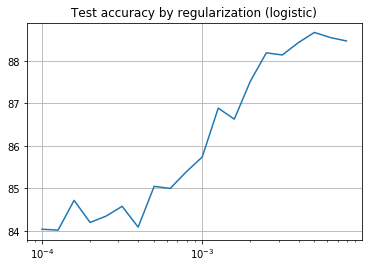

In [42]:
plt.semilogx(beta_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

Thus, let's choose `beta = 1e-2` for as our regularization parameter and train our model once more

In [40]:
num_steps = 3001

with tf.Session(graph=graphLogistic) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_data : batch_data, tf_train_labels : batch_labels, beta : 1e-2}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 49.795681
Minibatch accuracy: 10.9%
Validation accuracy: 15.3%
Minibatch loss at step 500: 0.744562
Minibatch accuracy: 86.7%
Validation accuracy: 81.4%
Minibatch loss at step 1000: 0.800607
Minibatch accuracy: 80.5%
Validation accuracy: 81.2%
Minibatch loss at step 1500: 0.566135
Minibatch accuracy: 83.6%
Validation accuracy: 81.1%
Minibatch loss at step 2000: 0.648305
Minibatch accuracy: 88.3%
Validation accuracy: 81.2%
Minibatch loss at step 2500: 0.782469
Minibatch accuracy: 78.9%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.784390
Minibatch accuracy: 80.5%
Validation accuracy: 81.4%
Test accuracy: 88.6%


<hr>
Let's repeat the same procedure with the Neural Net

In [76]:
hidden_nodes = 1024

def hidden_layer(tf_data, tf_weights, tf_biases):
    return tf.nn.relu(tf.matmul(tf_data, tf_weights) + tf_biases)

graphNN = tf.Graph()
with graphNN.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_data = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    beta = tf.placeholder(tf.float32) # Regularization parameter - fed during training
    weights_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_2 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Hidden Layer 1
    hidden_layer_1 = hidden_layer(tf_train_data, weights_1, biases_1)
    
    # Training computation.
    logits = tf.matmul(hidden_layer_1, weights_2) + biases_2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) + 
        beta * (tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_1)))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(hidden_layer(tf_valid_dataset, weights_1, biases_1), weights_2) + biases_2)
    test_prediction = tf.nn.softmax(
        tf.matmul(hidden_layer(tf_test_dataset, weights_1, biases_1), weights_2) + biases_2)

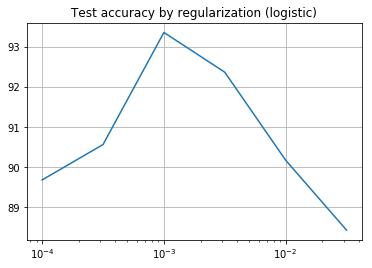

In [55]:
num_steps = 3001
beta_val = [pow(10, i) for i in np.arange(-4, -1, 0.5)]
accuracy_val = []

for beta_i in beta_val:
    with tf.Session(graph=graphNN) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_data : batch_data, tf_train_labels : batch_labels, beta : beta_i}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

plt.semilogx(beta_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

Let's choose `beta = 1e-3`

In [60]:
num_steps = 3001

with tf.Session(graph=graphNN) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_data : batch_data, tf_train_labels : batch_labels, beta : 1e-3}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 731.861572
Minibatch accuracy: 8.6%
Validation accuracy: 35.1%
Minibatch loss at step 500: 198.589935
Minibatch accuracy: 80.5%
Validation accuracy: 79.3%
Minibatch loss at step 1000: 114.691025
Minibatch accuracy: 78.9%
Validation accuracy: 81.9%
Minibatch loss at step 1500: 68.531052
Minibatch accuracy: 89.8%
Validation accuracy: 83.2%
Minibatch loss at step 2000: 41.115921
Minibatch accuracy: 89.8%
Validation accuracy: 85.1%
Minibatch loss at step 2500: 25.154716
Minibatch accuracy: 88.3%
Validation accuracy: 85.8%
Minibatch loss at step 3000: 15.424421
Minibatch accuracy: 88.3%
Validation accuracy: 86.4%
Test accuracy: 92.9%


Let's compare these results to what we got without regularization in Assignment 2

|      Model     || Without Regularization || With Regularization |
|----------------||------------------------||---------------------|
|    Logistic    ||          86.0%         ||         88.6%       |
| Neural Network ||          89.7%         ||         92.9%       |


<hr>
## Problem 2
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

In [78]:
num_steps = 101
batches = 5

with tf.Session(graph=graphNN) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: To demonstrate overfitting, restrict only 5 batches.
        offset = step % batches
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_data : batch_data, tf_train_labels : batch_labels, beta : 1e-2}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3507.968506
Minibatch accuracy: 10.2%
Validation accuracy: 29.8%
Minibatch loss at step 10: 2842.890137
Minibatch accuracy: 100.0%
Validation accuracy: 62.0%
Minibatch loss at step 20: 2571.710205
Minibatch accuracy: 100.0%
Validation accuracy: 62.0%
Minibatch loss at step 30: 2326.391602
Minibatch accuracy: 100.0%
Validation accuracy: 62.0%
Minibatch loss at step 40: 2104.476318
Minibatch accuracy: 100.0%
Validation accuracy: 62.0%
Minibatch loss at step 50: 1903.734619
Minibatch accuracy: 100.0%
Validation accuracy: 62.0%
Minibatch loss at step 60: 1722.136841
Minibatch accuracy: 100.0%
Validation accuracy: 62.0%
Minibatch loss at step 70: 1557.863281
Minibatch accuracy: 100.0%
Validation accuracy: 62.0%
Minibatch loss at step 80: 1409.259277
Minibatch accuracy: 100.0%
Validation accuracy: 62.0%
Minibatch loss at step 90: 1274.832153
Minibatch accuracy: 100.0%
Validation accuracy: 62.0%
Minibatch loss at step 100: 1153.226074
Minibatch accuracy: 

<hr>
## Problem 3
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

In [65]:
batch_size = 128
hidden_nodes = 1024

graphDropout = tf.Graph()
with graphDropout.as_default():
    
    # Training data
    tf_train_data = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    
    # Weights and Biases
    keep_prob = tf.placeholder(tf.float32) # The amount of examples to be kept - fed during training
    weights_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_2 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Hidden layer
    hidden_layer_1 = tf.nn.relu(tf.matmul(tf_train_data, weights_1) + biases_1)
    dropout_1 = tf.nn.dropout(hidden_layer_1, keep_prob)
    
    # Loss
    logits = tf.matmul(dropout_1, weights_2) + biases_2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(
        tf.nn.relu(tf.matmul(tf_valid_data, weights_1) + biases_1), weights_2) + biases_2)
    test_prediction = tf.nn.softmax(tf.matmul(
        tf.nn.relu(tf.matmul(tf_test_data, weights_1) + biases_1), weights_2) + biases_2)

In [74]:
num_steps = 3001
to_keep = 0.5

with tf.Session(graph=graphDropout) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_data : batch_data, tf_train_labels : batch_labels, keep_prob : to_keep}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 451.949768
Minibatch accuracy: 11.7%
Validation accuracy: 37.5%
Minibatch loss at step 500: 38.362003
Minibatch accuracy: 78.1%
Validation accuracy: 80.3%
Minibatch loss at step 1000: 15.692574
Minibatch accuracy: 74.2%
Validation accuracy: 79.8%
Minibatch loss at step 1500: 11.263721
Minibatch accuracy: 71.1%
Validation accuracy: 78.8%
Minibatch loss at step 2000: 4.313048
Minibatch accuracy: 76.6%
Validation accuracy: 79.5%
Minibatch loss at step 2500: 4.352523
Minibatch accuracy: 67.2%
Validation accuracy: 79.7%
Minibatch loss at step 3000: 4.072167
Minibatch accuracy: 68.8%
Validation accuracy: 79.4%
Test accuracy: 87.0%


Now, let's investigate the extreme case of overfitting

In [72]:
num_steps = 101
to_keep = 0.5
batches = 5

with tf.Session(graph=graphDropout) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: To simulate overfitting, we are restricting dataset to only 5 batches
        offset = step % batches
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_data : batch_data, tf_train_labels : batch_labels, keep_prob : to_keep}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 396.542297
Minibatch accuracy: 9.4%
Validation accuracy: 25.3%
Minibatch loss at step 10: 20.435863
Minibatch accuracy: 93.0%
Validation accuracy: 68.9%
Minibatch loss at step 20: 0.474351
Minibatch accuracy: 99.2%
Validation accuracy: 69.5%
Minibatch loss at step 30: 1.412732
Minibatch accuracy: 97.7%
Validation accuracy: 68.7%
Minibatch loss at step 40: 0.391184
Minibatch accuracy: 99.2%
Validation accuracy: 68.7%
Minibatch loss at step 50: 5.638687
Minibatch accuracy: 97.7%
Validation accuracy: 68.3%
Minibatch loss at step 60: 0.000018
Minibatch accuracy: 100.0%
Validation accuracy: 69.2%
Minibatch loss at step 70: 0.799878
Minibatch accuracy: 98.4%
Validation accuracy: 68.8%
Minibatch loss at step 80: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.5%
Minibatch loss at step 90: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.8%
Minibatch loss at step 100: 0.678572
Minibatch accuracy: 99.2%
Validation accuracy: 69.1%
Test

Notice that event after the minibatch accuracy reaches 100%, it wavers a bit and drops. This was not the case in L2 regularization.

<hr>
## Problem 4
Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:
```
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
```

In [102]:
batch_size = 128

hidden_nodes_1 = 1024
hidden_nodes_2 = 512
hidden_nodes_3 = 256

def hidden_layer(tf_data, tf_weights, tf_biases):
    return tf.nn.relu(tf.matmul(tf_data, tf_weights) + tf_biases)

graphMultiLayer = tf.Graph()
with graphMultiLayer.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes], stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes_1]))
    weights_2 = tf.Variable(
        tf.truncated_normal([hidden_nodes_1, hidden_nodes_2], stddev=np.sqrt(2.0 / hidden_nodes_1)))
    biases_2 = tf.Variable(tf.zeros([hidden_nodes_2]))
    weights_3 = tf.Variable(
        tf.truncated_normal([hidden_nodes_2, hidden_nodes_3], stddev=np.sqrt(2.0 / hidden_nodes_2)))
    biases_3 = tf.Variable(tf.zeros([hidden_nodes_3]))
    weights_4 = tf.Variable(
        tf.truncated_normal([hidden_nodes_3, num_labels], stddev=np.sqrt(2.0 / hidden_nodes_3)))
    biases_4 = tf.Variable(tf.zeros([num_labels]))
    steps = tf.Variable(0)
    
    # Hidden Layers
    hidden_layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    dropout_1 = tf.nn.dropout(hidden_layer_1, 0.5)
    hidden_layer_2 = tf.nn.relu(tf.matmul(dropout_1, weights_2) + biases_2)
    dropout_2 = tf.nn.dropout(hidden_layer_2, 0.5)
    hidden_layer_3 = tf.nn.relu(tf.matmul(dropout_2, weights_3) + biases_3)
    dropout_3 = tf.nn.dropout(hidden_layer_3, 0.5)
    
    # Training computation.
    logits = tf.matmul(dropout_3, weights_4) + biases_4
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, steps, 5000, 0.80, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=steps)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    layer2_valid = tf.nn.relu(tf.matmul(layer1_valid, weights_2) + biases_2)
    layer3_valid = tf.nn.relu(tf.matmul(layer2_valid, weights_3) + biases_3)
    logits_valid = tf.matmul(layer3_valid, weights_4) + biases_4
    valid_prediction = tf.nn.softmax(logits_valid)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    layer2_test = tf.nn.relu(tf.matmul(layer1_test, weights_2) + biases_2)
    layer3_test = tf.nn.relu(tf.matmul(layer2_test, weights_3) + biases_3)
    logits_test = tf.matmul(layer3_test, weights_4) + biases_4
    test_prediction = tf.nn.softmax(logits_test)

In [105]:
num_steps = 10001

with tf.Session(graph=graphMultiLayer) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.832816
Minibatch accuracy: 9.4%
Validation accuracy: 26.3%
Minibatch loss at step 1000: 0.637375
Minibatch accuracy: 82.0%
Validation accuracy: 84.6%
Minibatch loss at step 2000: 0.421964
Minibatch accuracy: 90.6%
Validation accuracy: 85.6%
Minibatch loss at step 3000: 0.560507
Minibatch accuracy: 79.7%
Validation accuracy: 86.6%
Minibatch loss at step 4000: 0.469717
Minibatch accuracy: 88.3%
Validation accuracy: 86.9%
Minibatch loss at step 5000: 0.439082
Minibatch accuracy: 86.7%
Validation accuracy: 87.6%
Minibatch loss at step 6000: 0.605888
Minibatch accuracy: 84.4%
Validation accuracy: 87.9%
Minibatch loss at step 7000: 0.457738
Minibatch accuracy: 86.7%
Validation accuracy: 88.7%
Minibatch loss at step 8000: 0.619453
Minibatch accuracy: 81.2%
Validation accuracy: 88.5%
Minibatch loss at step 9000: 0.540814
Minibatch accuracy: 86.7%
Validation accuracy: 88.8%
Minibatch loss at step 10000: 0.381421
Minibatch accuracy: 87.5%
Validation accura

An accuracy of 94.6% is quite impressive. If we could go deeper, we can definitely improve performance
<hr>